In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

In [2]:
# 탄력적으로 GPU memory 사용 방법
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

W0718 16:41:10.128461 139755598128960 deprecation.py:323] From <ipython-input-3-4dcbd946c02b>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0718 16:41:10.129085 139755598128960 deprecation.py:323] From /home/com26/.local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0718 16:41:10.129489 139755598128960 deprecation.py:323] From /home/com26/.local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future vers

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [127]:

# GPU를 사용가능하다면 CuDNNGRU를 사용합니다. 
if tf.test.is_gpu_available():
  #rnn = tf.keras.layers.CuDNNGRU
  rnn = tf.keras.layers.SimpleRNN
  #rnn = tf.keras.layers.LSTM
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [128]:
def build_model(vocab_size, rnn_units, batch_size):
  model = tf.keras.Sequential([
    rnn(10,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(28*28),
  ])
  return model

In [129]:
rnn_units = 1024
BATCH_SIZE = 32
n_input = 28 
total_batch = int(mnist.train.num_examples/BATCH_SIZE)

In [130]:
model = build_model(
  vocab_size = 1,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [131]:
train_images = []
train_labels = []
preds = []

cnt = 0
for i in range(total_batch):
    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
    train_labels.append(batch_xs)
    batch_xs = np.expand_dims(batch_xs, axis=2)
    train_images.append(batch_xs)
    # (batch_size, timesteps, input_dim)
    #print (batch_xs.shape)
    pred = model(batch_xs).numpy()
    preds.append(pred)
    
    cnt += 1
    if cnt%1==0:
        break
train_images = np.asarray(train_images)
train_images = train_images.reshape(-1, 28*28, 1)

train_labels = np.asarray(train_labels)
train_labels = train_labels.reshape(-1, 28*28)

In [132]:
import matplotlib.pyplot as plt

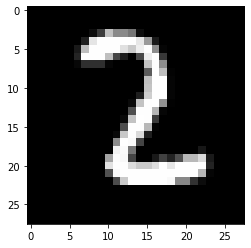

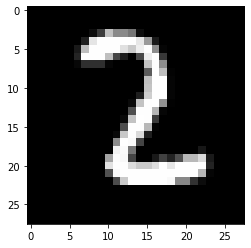

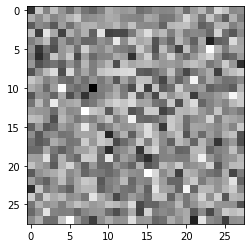

In [133]:
plt.imshow(train_images.reshape(-1, n_input, n_input)[0], cmap='gray')
plt.show()
plt.imshow(train_labels.reshape(-1, n_input, n_input)[0], cmap='gray')
plt.show()
plt.imshow(pred.reshape(-1, n_input, n_input)[0], cmap='gray')
plt.show()

In [134]:
def loss(labels, preds):
  return tf.keras.losses.MSE(labels, preds)

In [135]:
# optimizer로 Adam을 설정합니다.
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

In [136]:
checkpoint_dir = './training_checkpoints'
# checkpoint 파일의 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [137]:
# 학습 실행 
EPOCHS=3

history = model.fit(x=train_images, y=train_labels, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/3
32/32 [==============================] - 4s 120ms/sample - loss: 0.7220
Epoch 2/3
32/32 [==============================] - 4s 115ms/sample - loss: 9.9265
Epoch 3/3
32/32 [==============================] - 4s 116ms/sample - loss: 0.9973


In [138]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc=0)

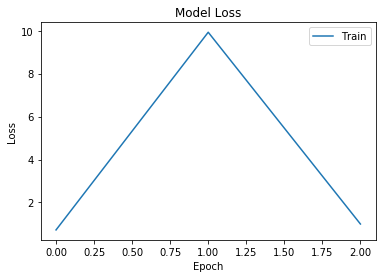

In [139]:
plot_loss(history)
plt.show()

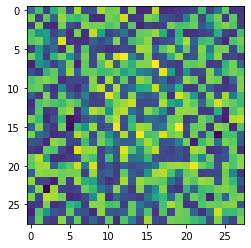

In [140]:
for img in model(train_images):
    plt.imshow(img.numpy().reshape(28,28))
    break